<a href="https://colab.research.google.com/github/kiarashk76/DL4NLP-2nd-Assignment/blob/master/2nd_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#mounting the google drive for accessing the dataset

from google.colab import drive
drive.mount('/content/drive')


In [0]:
!cp '/content/drive/My Drive/Datasets/imdb-movie-reviews-dataset.zip' '/content/'
!unzip imdb-movie-reviews-dataset.zip

In [0]:
import numpy as np
import os

DATA_PATH = '/content/aclImdb'

# listing training directories
train_pos = os.listdir(os.path.join(DATA_PATH, 'train/pos'))
for i in range(len(train_pos)):
  train_pos[i] = 'pos/' + train_pos[i] 
  
train_neg = os.listdir(os.path.join(DATA_PATH, 'train/neg'))
for i in range(len(train_neg)):
  train_neg[i] = 'neg/' + train_neg[i]

# listing test directories
test_pos = os.listdir(os.path.join(DATA_PATH, 'test/pos'))
for i in range(len(test_pos)):
  test_pos[i] = 'pos/' + test_pos[i] 
  
test_neg = os.listdir(os.path.join(DATA_PATH, 'test/neg'))
for i in range(len(test_neg)):
  test_neg[i] = 'neg/' + test_neg[i]
  
# extracting validation directories from training
np.random.shuffle(train_pos)
np.random.shuffle(train_neg)

val_pos = train_pos[0:2500]
val_neg = train_neg[0:2500]

del train_pos[0:2500]
del train_neg[0:2500]

# shuffling pos and neg trainings
X_train = train_pos +  train_neg 
y_train = [1] * len(train_pos) + [0] * len(train_neg)

np.random.seed(314)
np.random.shuffle(X_train) 
np.random.seed(314) 
np.random.shuffle(y_train)

# creating pos and neg validations
X_val = val_pos +  val_neg 
y_val = [1] * len(val_pos) + [0] * len(val_neg)

# creating pos and neg tests
X_test = test_pos +  test_neg 
y_test = [1] * len(test_pos) + [0] * len(test_neg)



In [0]:
def create_id2word(vocab):
  results = []
  for i in vocab:
    results.append(i[0])
  return results

def create_word2id(vocab):
  results = dict()
  for i in range(len(vocab)):
    results[vocab[i][0]] = i
  return results

In [0]:
vocab = dict()

# extract the 2000 most frequent words in our dataset
for address in X_train:
  file = open(os.path.join(DATA_PATH, 'train', address), 'r')
  txt = file.read().strip().lower()
  words = txt.split()
  for w in words:
    if w in vocab:
      vocab[w] += 1
    else:
      vocab[w] = 1


vocab = sorted(vocab.items(), key=lambda x: x[1], reverse=True)
vocab = vocab[0:2000]

id2word = create_id2word(vocab)
word2id = create_word2id(vocab)

In [0]:
# extract feature vectors for training

x_train = np.zeros( (len(X_train),2000), dtype=int)
i = 0
for address in X_train:
  file = open(os.path.join(DATA_PATH, 'train', address), 'r')
  txt = file.read().strip().lower()
  words = txt.split()
  for w in words:
    if w in word2id:
      x_train[i][word2id[w]] = 1
  i += 1
  
# extract feature vectors for validation
x_val = np.zeros( (len(X_val),2000), dtype=int)
i = 0
for address in X_val:
  file = open(os.path.join(DATA_PATH, 'train', address), 'r')
  txt = file.read().strip().lower()
  words = txt.split()
  for w in words:
    if w in word2id:
      x_val[i][word2id[w]] = 1
  i += 1
  
# extract feature vectors for test
x_test = np.zeros( (len(X_test),2000), dtype=int)
i = 0
for address in X_test:
  file = open(os.path.join(DATA_PATH, 'test', address), 'r')
  txt = file.read().strip().lower()
  words = txt.split()
  for w in words:
    if w in word2id:
      x_test[i][word2id[w]] = 1
  i += 1

In [0]:
import pickle


y_train = np.asarray(y_train)
y_val = np.asarray(y_val)
y_test = np.asarray(y_test)

# save the data into drive
pickle.dump([x_train, y_train, x_val, y_val, x_test, y_test], open("data.pkl", "wb")) 
pickle.dump([id2word, word2id],  open("aux.pkl", "wb"))

# load from the saved 
# x_train, y_train, x_val, y_val, x_test, y_test = pickle.load( open("data.pkl", "rb"))
# id2word, word2id = pickle.load( open("aux.pkl", "rb"))

In [0]:
import matplotlib.pyplot as plt

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def sigmoid_derive(x):
  return sigmoid(x)* (1-sigmoid(x))

In [0]:
class layer():
  """
  This class is for simulating each layer of a NN model: 
  - input
  - weights
  - activation function
  - derivative of activation function
  - output before activation
  - output after activation
  """
  def __init__(self, shape, act_function):
    self.W = np.random.uniform(-0.5 ,0.5 , shape)
    self.b = np.random.uniform(-0.5 ,0.5 , shape[1])
    self.grad = np.random.uniform(-0.5, 0.5, shape)
    self.act_function = act_function
  def activation_function(self, x):
    if self.act_function == "sigmoid":
      return sigmoid(x)

  def activation_function_derivative(self, x):
    if self.act_function == "sigmoid":
      return sigmoid_derive(x)
  
  def calculate_output(self, X):
    self.x = X
    self.z = np.dot(X, self.W) + self.b 
    self.y = self.activation_function(self.z)

In [0]:
class model():
  """
  This class is for simulating a multi layer model using the Layer class. Methods:
  - set train / validation / test data
  - add layers without limitation (ofcourse there is a time limitation)
  - calculate forward propagation
  - calculate back propagation for training the model
  - testing the model with the best model with regard to validation accuracy
  """
  def __init__(self):
    self.layers_list = []
    self.best_val_acc = 0

  def set_training_data(self, X_train, y_train):
    self.X_train = X_train #(20000, 2000)
    self.y_train = y_train #(20000, )
    
  def set_validation_data(self, X_val, y_val):
    self.X_val = X_val #(5000, 2000)
    self.y_val = y_val #(5000, )
    
  def set_test_data(self, X_test, y_test):
    self.X_test = X_test #(25000,2000) 
    self.y_test = y_test #(25000)
  
  def set_input_layer(self, input_features):
    self.input_features = input_features

  def set_output_layer(self, output_num):
    self.output_num = output_num

  def add_layer(self, weights_num, act_function = "sigmoid"):
    # add a layer with the number of neurons given in the parameter
    if len(self.layers_list) == 0:
      input_shape = self.X_train.shape
      l = layer([self.input_features, weights_num], act_function)
      self.layers_list.append(l)
    else:
      last_layer_shape = self.layers_list[-1].W.shape
      l = layer([last_layer_shape[1], weights_num], act_function)
      self.layers_list.append(l)

  def forward_propagation(self, X):
    # calculating the forward propagation and saving 
    # the middle point data in the layers
    if len(self.layers_list) == 0:
      print("No layers exist")
      return 0 
    for i,lay in enumerate(self.layers_list):
      if i == 0:
        lay.calculate_output(X)
      else:
        last_layer_output = self.layers_list[i-1].y
        lay.calculate_output(last_layer_output)
    
  def train(self, batch_size = 20, learning_rate = 0.1, num_epochs = 10):
    self.add_layer(self.output_num)
    total_number_of_batches = int(self.X_train.shape[0] / batch_size)
    self.loss_list = []
    self.acc_train = []
    self.acc_val = []
    for i in range(num_epochs):
      print("epoch ",i,"-> ",end='')
      total_loss = 0
      for j in range(total_number_of_batches):
        X = self.X_train[batch_size*j : batch_size* (j+1)] # (batch_size, 2000)
        y = self.y_train[batch_size*j : batch_size* (j+1)] # (batch_size, )

        self.forward_propagation(X)
        
        # calculating derivatives with respect to layers
        for i in range(len(self.layers_list) - 1, -1, -1):
          current_layer = self.layers_list[i]    
          if i == len(self.layers_list) - 1:
            if  (current_layer.y * ((current_layer.y) - 1)).all() != 0:
              current_layer.grad = (y[:, None] - current_layer.y) / (current_layer.y * ((current_layer.y) - 1))
          else:
            last_layer = self.layers_list[i+1]
            current_layer.grad = np.dot(last_layer.grad * last_layer.activation_function_derivative(last_layer.z), last_layer.W.T)

        # calculating derivatives with respect to weights
        for i in range(len(self.layers_list)):
          current_layer = self.layers_list[i]
          gradW = np.dot(current_layer.x.T, current_layer.grad * current_layer.activation_function_derivative(current_layer.z)) / current_layer.grad.shape[0]
          gradb = np.mean(current_layer.grad * current_layer.activation_function_derivative(current_layer.z))

          current_layer.W -= learning_rate * gradW
          current_layer.b -= learning_rate * gradb
      
      # calculating training & validation accuracy
      train_acc = self.calculate_accuracy(self.X_train, self.y_train, self)
      val_acc = self.calculate_accuracy(self.X_val, self.y_val, self)
      self.acc_train.append(train_acc)
      self.acc_val.append(val_acc)

      # saving the best model with regard to validation accuracy
      if (val_acc > self.best_val_acc):
        self.best_val_acc = val_acc
        self.save_model()                 
      print("train acc:", train_acc, "validation acc:",val_acc)
  
  def predict_label(self, X, model):
    # predicting the output for input (X) given the model
    model.threshhold = 0.5
    model.forward_propagation(X)
    prob = model.layers_list[-1].y
    predict = np.empty_like(prob)
    for i in range(len(prob)):
      if prob[i][0] > model.threshhold :
        predict[i] = 1
      else:
        predict[i] = 0
    return predict

  def plot_accuracy(self):
    plt.subplot(2,1,2)
    plt.plot(self.acc_train, label= 'train accuracy')
    plt.plot(self.acc_val, label= 'validation accuracy')    
    plt.xlabel("iterations")
    plt.legend(loc='best')

  def save_model(self):
    # save the current model object
    self.saved_model = self

  def calculate_accuracy(self, X, y, model):
      counter = 0 
      prediction = self.predict_label(X, model)
      for i in range(len(prediction)):
        if prediction[i] == y[i]:
          counter += 1
      accuracy = counter / len(prediction)
      return accuracy
  
  def test_model(self, X = None, y = None):
    # test the best model for the given data
    # if no data given to this function test with the preset test data
    if (not X or not y):
      return self.calculate_accuracy(self.X_test, self.y_test, self.saved_model)
    else:
      return self.calculate_accuracy(X, y, self.saved_model)



epoch  0 -> train acc: 0.7408 validation acc: 0.7326
epoch  1 -> train acc: 0.78555 validation acc: 0.7646
epoch  2 -> train acc: 0.80865 validation acc: 0.779
epoch  3 -> train acc: 0.8229 validation acc: 0.7916
epoch  4 -> train acc: 0.83385 validation acc: 0.7988
epoch  5 -> train acc: 0.8435 validation acc: 0.8042
epoch  6 -> train acc: 0.85135 validation acc: 0.8068
epoch  7 -> train acc: 0.8569 validation acc: 0.8088
epoch  8 -> train acc: 0.86135 validation acc: 0.8114
epoch  9 -> train acc: 0.86585 validation acc: 0.8104
epoch  10 -> train acc: 0.86785 validation acc: 0.8094
epoch  11 -> train acc: 0.8726 validation acc: 0.8106
epoch  12 -> train acc: 0.8768 validation acc: 0.8104
epoch  13 -> train acc: 0.88025 validation acc: 0.8096
epoch  14 -> train acc: 0.8843 validation acc: 0.8086
epoch  15 -> train acc: 0.8888 validation acc: 0.8088
epoch  16 -> train acc: 0.8932 validation acc: 0.8074
epoch  17 -> train acc: 0.89735 validation acc: 0.8058
epoch  18 -> train acc: 0.9027

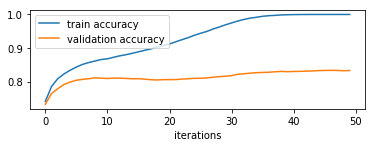

In [14]:
if __name__ == "__main__":
  
  m = model()
  m.set_training_data(x_train, y_train)
  m.set_validation_data(x_val, y_val)
  m.set_test_data(x_test, y_test) 
  
  m.set_input_layer(2000)
  m.set_output_layer(1)

  m.add_layer(200, act_function= "sigmoid")

  m.train(batch_size = 20, learning_rate = 0.1, num_epochs = 50)
  print("test accuracy : ", m.test_model())
  m.plot_accuracy()